In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [37]:
from utils import get_data, create_custom_color_palette

# type_data = "all_data"
type_data = "same_seed"
# type_data = "different_seed"

data = get_data(type_data)

In [38]:
def get_techniques_and_name(data):
    platform = data["platform"]["platform"]

    def _recursive_get_name_and_techniques(item):
        if "techniques" not in item:
            print(f"Warning: 'techniques' key not found in item: {item}")
        name_and_techniques = [[item["name"], item["techniques"]]]
        for reply in item.get("replies", []):
            name_and_techniques.extend(_recursive_get_name_and_techniques(reply))
        return name_and_techniques

    techniques = []
    for post in platform:
        name_and_techniques = _recursive_get_name_and_techniques(post)
        techniques.extend(name_and_techniques.copy())

    return techniques

In [39]:
def get_model_for_person(data, person_name):
    """Get the model name for a given person"""
    for agent in data["people_agents"]:
        if agent["name"] == person_name:
            return agent["model_name"]

    for agent in data["candidate_agents"]:
        if agent["name"] == person_name:
            return agent["model_name"]
    return None


def get_person_type(data, person_name):
    """Get whether a person is a voter or candidate"""
    candidate_names = [agent["name"] for agent in data.get("candidate_agents", [])]
    if person_name in candidate_names:
        return "candidate"

    voter_names = [agent["name"] for agent in data.get("people_agents", [])]
    if person_name in voter_names:
        return "voter"

    return "unknown"

In [40]:
def plot_overall_persuasion_techniques(data, type_data=None):
    """Create horizontal bar chart of all persuasion techniques used"""
    techniques_data = get_techniques_and_name(data)

    all_techniques = []
    for i in range(0, len(techniques_data)):
        all_techniques.extend(techniques_data[i][1])

    technique_counts = pd.Series(all_techniques).value_counts()

    plt.figure(figsize=(12, 8))

    colors = create_custom_color_palette(len(technique_counts))
    bars = plt.barh(range(len(technique_counts)), technique_counts.values, color=colors)

    plt.yticks(range(len(technique_counts)), technique_counts.index)
    plt.xlabel("Persuasion count")
    title = "Persuasion technique ranking"
    if type_data:
        title += f" ({type_data})"
    plt.title(title)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

In [41]:
def process_techniques_by_type(data):
    """Process techniques data and organize by voter/candidate and model"""
    techniques_data = get_techniques_and_name(data)

    voter_techniques = {}
    candidate_techniques = {}

    for i in range(0, len(techniques_data)):
        person_name = techniques_data[i][0]
        techniques = techniques_data[i][1]

        model = get_model_for_person(data, person_name)
        person_type = get_person_type(data, person_name)

        target_dict = (
            voter_techniques if person_type == "voter" else candidate_techniques
        )

        if model not in target_dict:
            target_dict[model] = {}

        for technique in techniques:
            if technique not in target_dict[model]:
                target_dict[model][technique] = 0
            target_dict[model][technique] += 1

    return voter_techniques, candidate_techniques

In [42]:
def create_stacked_bar_chart(model_techniques, person_type_name, type_data=None):
    """Create a stacked horizontal bar chart for given model techniques"""
    if not model_techniques:
        print(f"No data found for {person_type_name}")
        return

    all_techniques = set()
    for model_data in model_techniques.values():
        all_techniques.update(model_data.keys())
    all_techniques = sorted(list(all_techniques))

    models = list(model_techniques.keys())
    technique_matrix = []

    for model in models:
        row = []
        for technique in all_techniques:
            row.append(model_techniques[model].get(technique, 0))
        technique_matrix.append(row)

    fig, ax = plt.subplots(figsize=(14, 8))

    model_totals = [sum(row) for row in technique_matrix]
    sorted_indices = sorted(
        range(len(models)), key=lambda i: model_totals[i], reverse=True
    )

    sorted_models = [models[i] for i in sorted_indices]
    sorted_matrix = [technique_matrix[i] for i in sorted_indices]

    colors = create_custom_color_palette(len(all_techniques))
    left = np.zeros(len(sorted_models))

    for i, technique in enumerate(all_techniques):
        values = [row[i] for row in sorted_matrix]
        bars = ax.barh(
            range(len(sorted_models)),
            values,
            left=left,
            label=technique,
            color=colors[i],
        )
        left += values

    ax.set_yticks(range(len(sorted_models)))
    ax.set_yticklabels([model.split("/")[-1] for model in sorted_models])
    ax.tick_params(axis="y", labelsize=14)
    ax.set_xlabel("Persuasion count", fontsize=14)
    title = f"{person_type_name} persuasion usage"
    if type_data:
        title += f" ({type_data})"
    ax.set_title(title, fontsize=16)
    ax.invert_yaxis()

    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)

    plt.tight_layout()
    plt.show()


def plot_voter_candidate_persuasion_techniques(data, type_data=None):
    """Create separate stacked horizontal bar charts for voters and candidates"""
    voter_techniques, candidate_techniques = process_techniques_by_type(data)

    create_stacked_bar_chart(voter_techniques, "Voters", type_data)
    create_stacked_bar_chart(candidate_techniques, "Candidates", type_data)

In [43]:
def combine_all_data_techniques_and_name(all_data):
    """Get techniques and names from all simulation data combined"""
    all_techniques = []

    for data in all_data:
        techniques = get_techniques_and_name(data)
        all_techniques.extend([techniques.copy()])

    return all_techniques

In [44]:
def process_corrected_combined_techniques_by_type(all_data):
    """Process techniques data from all simulations and organize by voter/candidate and model"""
    voter_techniques = {}
    candidate_techniques = {}

    total = 0
    for data in all_data:
        voter_techniques_data, candidate_techniques_data = process_techniques_by_type(
            data
        )

        for model, techniques in voter_techniques_data.items():
            if model not in voter_techniques:
                voter_techniques[model] = {}
            for technique, count in techniques.items():
                if technique not in voter_techniques[model]:
                    voter_techniques[model][technique] = 0
                voter_techniques[model][technique] += count
                total += count

        for model, techniques in candidate_techniques_data.items():
            if model not in candidate_techniques:
                candidate_techniques[model] = {}
            for technique, count in techniques.items():
                if technique not in candidate_techniques[model]:
                    candidate_techniques[model][technique] = 0
                candidate_techniques[model][technique] += count
                total += count

    return voter_techniques, candidate_techniques

In [45]:
def get_global_technique_names():
    all_data_combined = get_data("all_data")
    techniques_data = combine_all_data_techniques_and_name(all_data_combined)

    all_techniques = []
    for sim in techniques_data:
        for i in range(0, len(sim)):
            all_techniques.extend(sim[i][1])

    technique_counts = pd.Series(all_techniques).value_counts()
    return technique_counts.index.tolist()


def plot_combined_overall_persuasion_techniques(all_data, type_data=None):
    all_data_combined = get_data("all_data")
    global_techniques_data = combine_all_data_techniques_and_name(all_data_combined)

    global_all_techniques = []
    for sim in global_techniques_data:
        for i in range(0, len(sim)):
            global_all_techniques.extend(sim[i][1])

    global_technique_counts = pd.Series(global_all_techniques).value_counts()
    global_ordered_techniques = global_technique_counts.index.tolist()

    current_techniques_data = combine_all_data_techniques_and_name(all_data)
    current_all_techniques = []
    for sim in current_techniques_data:
        for i in range(0, len(sim)):
            current_all_techniques.extend(sim[i][1])

    current_technique_counts = pd.Series(current_all_techniques).value_counts()

    plt.figure(figsize=(12, 8))

    colors = create_custom_color_palette(len(global_ordered_techniques))
    technique_to_color = {
        tech: colors[i] for i, tech in enumerate(global_ordered_techniques)
    }

    display_techniques = []
    display_counts = []
    display_colors = []

    for technique in current_technique_counts.index:
        count = current_technique_counts[technique]
        display_techniques.append(technique)
        display_counts.append(count)
        display_colors.append(technique_to_color[technique])

    bars = plt.barh(
        range(len(display_techniques)), display_counts, color=display_colors
    )

    plt.yticks(range(len(display_techniques)), display_techniques)
    plt.xlabel("Persuasion count")
    title = "Total Persuasion Technique Ranking"
    if type_data:
        title += f" ({type_data})"
    plt.title(title)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

    return global_ordered_techniques

In [46]:
def create_combined_side_by_side_chart(
    voter_techniques,
    candidate_techniques,
    all_data,
    type_data=None,
    x_axis_label="Persuasion count",
):
    if not voter_techniques and not candidate_techniques:
        print("No data found for voters or candidates")
        return

    all_data_combined = get_data("all_data")
    global_techniques_data = combine_all_data_techniques_and_name(all_data_combined)

    global_all_techniques = []
    for sim in global_techniques_data:
        for i in range(0, len(sim)):
            global_all_techniques.extend(sim[i][1])

    global_technique_counts = pd.Series(global_all_techniques).value_counts()
    global_ordered_techniques = global_technique_counts.index.tolist()

    colors = create_custom_color_palette(len(global_ordered_techniques))
    technique_to_color = {
        tech: colors[i] for i, tech in enumerate(global_ordered_techniques)
    }

    current_techniques_data = combine_all_data_techniques_and_name(all_data)
    current_all_techniques = []
    for sim in current_techniques_data:
        for i in range(0, len(sim)):
            current_all_techniques.extend(sim[i][1])

    current_technique_counts = pd.Series(current_all_techniques).value_counts()
    current_ordered_techniques = current_technique_counts.index.tolist()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    def create_subplot(ax, model_techniques, person_type_name):
        if not model_techniques:
            ax.text(
                0.5,
                0.5,
                f"No data for {person_type_name}",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
            return []

        models = list(model_techniques.keys())
        model_totals = []
        for model in models:
            total = sum(
                model_techniques[model].get(tech, 0)
                for tech in current_ordered_techniques
            )
            model_totals.append(total)

        sorted_indices = sorted(
            range(len(models)), key=lambda i: model_totals[i], reverse=True
        )
        sorted_models = [models[i] for i in sorted_indices]

        left = np.zeros(len(sorted_models))
        legend_items = []

        # Use global_ordered_techniques to match the overall chart order
        for technique in global_ordered_techniques:
            values = []
            for i in sorted_indices:
                model = models[i]
                values.append(model_techniques[model].get(technique, 0))

            if any(v > 0 for v in values):
                bars = ax.barh(
                    range(len(sorted_models)),
                    values,
                    left=left,
                    label=technique,
                    color=technique_to_color[technique],
                )
                legend_items.append((bars, technique))
                left += values

        ax.set_yticks(range(len(sorted_models)))
        ax.set_yticklabels([model.split("/")[-1] for model in sorted_models])
        ax.tick_params(labelsize=14)
        ax.set_xlabel(x_axis_label, fontsize=14)
        title = f"{person_type_name} Persuasion Usage"
        if type_data:
            title += f" ({type_data})"
        ax.set_title(title, fontsize=15)
        ax.invert_yaxis()

        return legend_items

    voter_legend = create_subplot(ax1, voter_techniques, "Voters")
    candidate_legend = create_subplot(ax2, candidate_techniques, "Candidates")

    all_legend_items = {}
    for bars, technique in voter_legend + candidate_legend:
        if technique not in all_legend_items:
            all_legend_items[technique] = bars

    if all_legend_items:
        ordered_legend_techniques = [
            t for t in current_ordered_techniques if t in all_legend_items
        ]
        legend_handles = [all_legend_items[t] for t in ordered_legend_techniques]

        fig.legend(
            legend_handles,
            ordered_legend_techniques,
            bbox_to_anchor=(0.5, 0),
            loc="upper center",
            ncol=min(len(legend_handles), 7),
            fontsize=12,
        )

    plt.tight_layout()
    plt.show()

In [47]:
def plot_combined_voter_candidate_persuasion_techniques(all_data, type_data):
    voter_techniques, candidate_techniques = (
        process_corrected_combined_techniques_by_type(all_data)
    )

    plot_combined_overall_persuasion_techniques(all_data, type_data)

    create_combined_side_by_side_chart(
        voter_techniques, candidate_techniques, all_data, type_data
    )

In [48]:
same_seed_data = get_data("same_seed")
different_seed_data = get_data("different_seed")

print("Same seed results:")
plot_combined_voter_candidate_persuasion_techniques(same_seed_data, "same_seed")

print("\nDifferent seed results:")
plot_combined_voter_candidate_persuasion_techniques(
    different_seed_data, "different_seed"
)

KeyboardInterrupt: 

In [ ]:
from collections import Counter


def analyze_dataset(dataset_name, dataset):
    print(f"=== {dataset_name.upper()} ANALYSIS ===")
    voter_techniques, candidate_techniques = (
        process_corrected_combined_techniques_by_type(dataset)
    )

    voter_total_counter = Counter()
    for model in voter_techniques:
        voter_total_counter.update(voter_techniques[model])

    voter_total = sum(voter_total_counter.values())

    candidate_total_counter = Counter()
    for model in candidate_techniques:
        candidate_total_counter.update(candidate_techniques[model])

    candidate_total = sum(candidate_total_counter.values())

    print("Total persuasion techniques found:", voter_total + candidate_total)
    print("Number of techniques:", len(voter_total_counter + candidate_total_counter))
    print("\n" + "#" * 60 + "\n")

    print("Total voter persuasion techniques (all models):")
    print(f"Total techniques used: {voter_total}")
    print(f"Number of techniques: {len(voter_total_counter)}")
    for technique, count in voter_total_counter.most_common():
        percentage = (count / voter_total) * 100
        print(f"{technique}: {count} ({percentage:.1f}%)")
    print()

    print("Voter techniques per model:")
    for model, techniques in voter_techniques.items():
        model_total = sum(techniques.values())
        print(f"\nModel: {model} (Total: {model_total})")
        for technique, count in sorted(techniques.items(), key=lambda x: -x[1]):
            percentage = (count / model_total) * 100
            print(f"  {technique}: {count} ({percentage:.1f}%)")

    print("\n" + "#" * 60 + "\n")

    print("Total candidate persuasion techniques (all models):")
    print(f"Total techniques used: {candidate_total}")
    print(f"Number of techniques: {len(candidate_total_counter)}")
    for technique, count in candidate_total_counter.most_common():
        percentage = (count / candidate_total) * 100
        print(f"{technique}: {count} ({percentage:.1f}%)")
    print()

    print("Candidate techniques per model:")
    for model, techniques in candidate_techniques.items():
        model_total = sum(techniques.values())
        print(f"\nModel: {model} (Total: {model_total})")
        for technique, count in sorted(techniques.items(), key=lambda x: -x[1]):
            percentage = (count / model_total) * 100
            print(f"  {technique}: {count} ({percentage:.1f}%)")

    print("\n" + "=" * 80 + "\n")


same_seed_data = get_data("same_seed")
different_seed_data = get_data("different_seed")

analyze_dataset("same seed", same_seed_data)
analyze_dataset("different seed", different_seed_data)

=== SAME SEED ANALYSIS ===
Total persuasion techniques found: 69298
Number of techniques: 25

############################################################

Total voter persuasion techniques (all models):
Total techniques used: 54530
Number of techniques: 25
Appeal to Logic: 9240 (16.9%)
Appeal to Credibility: 7667 (14.1%)
Distraction: 5757 (10.6%)
Strategic Voting Suggestion: 5520 (10.1%)
Appeal to Emotion: 5317 (9.8%)
Vagueness: 4752 (8.7%)
Shifting the Burden of Proof: 3948 (7.2%)
Bandwagon Effect: 3516 (6.4%)
Sarcasm: 1890 (3.5%)
Appeal to Urgency: 1693 (3.1%)
Exaggeration: 1587 (2.9%)
Projection: 903 (1.7%)
Denial without Evidence: 751 (1.4%)
Appeal to Relationship: 667 (1.2%)
Confirmation Bias Exploitation: 568 (1.0%)
Deception: 234 (0.4%)
Minimization: 177 (0.3%)
Appeal to Rules: 97 (0.2%)
Gaslighting: 92 (0.2%)
Withholding Information: 72 (0.1%)
Lying: 57 (0.1%)
Feigning Ignorance: 18 (0.0%)
Humor: 3 (0.0%)
Information Overload: 2 (0.0%)
Self-Deprecation: 2 (0.0%)

Voter techniq

In [ ]:
print("=== Data Consistency Check ===")


current_techniques_data = combine_all_data_techniques_and_name(data)
current_all_techniques = []
for sim in current_techniques_data:
    for i in range(0, len(sim)):
        current_all_techniques.extend(sim[i][1])

print(len(current_all_techniques), "total techniques found in data")

chart_technique_counts = pd.Series(current_all_techniques).value_counts()
print("Chart technique counts:")
for technique, count in chart_technique_counts.head(10).items():
    print(f"{technique}: {count}")

print("\n" + "-" * 40 + "\n")

voter_techniques, candidate_techniques = process_corrected_combined_techniques_by_type(
    data
)
analysis_total_counter = Counter()
for model in voter_techniques:
    analysis_total_counter.update(voter_techniques[model])
for model in candidate_techniques:
    analysis_total_counter.update(candidate_techniques[model])

print("Analysis technique counts:")
for technique, count in analysis_total_counter.most_common(10):
    print(f"{technique}: {count}")

print("\nShould match between chart and analysis!")

=== Data Consistency Check ===
69298 total techniques found in data
Chart technique counts:
Appeal to Credibility: 11528
Appeal to Logic: 9787
Distraction: 8597
Vagueness: 8284
Appeal to Emotion: 6344
Strategic Voting Suggestion: 5841
Shifting the Burden of Proof: 3986
Bandwagon Effect: 3828
Sarcasm: 1941
Appeal to Urgency: 1815

----------------------------------------

Analysis technique counts:
Appeal to Credibility: 11528
Appeal to Logic: 9787
Distraction: 8597
Vagueness: 8284
Appeal to Emotion: 6344
Strategic Voting Suggestion: 5841
Shifting the Burden of Proof: 3986
Bandwagon Effect: 3828
Sarcasm: 1941
Appeal to Urgency: 1815

Should match between chart and analysis!


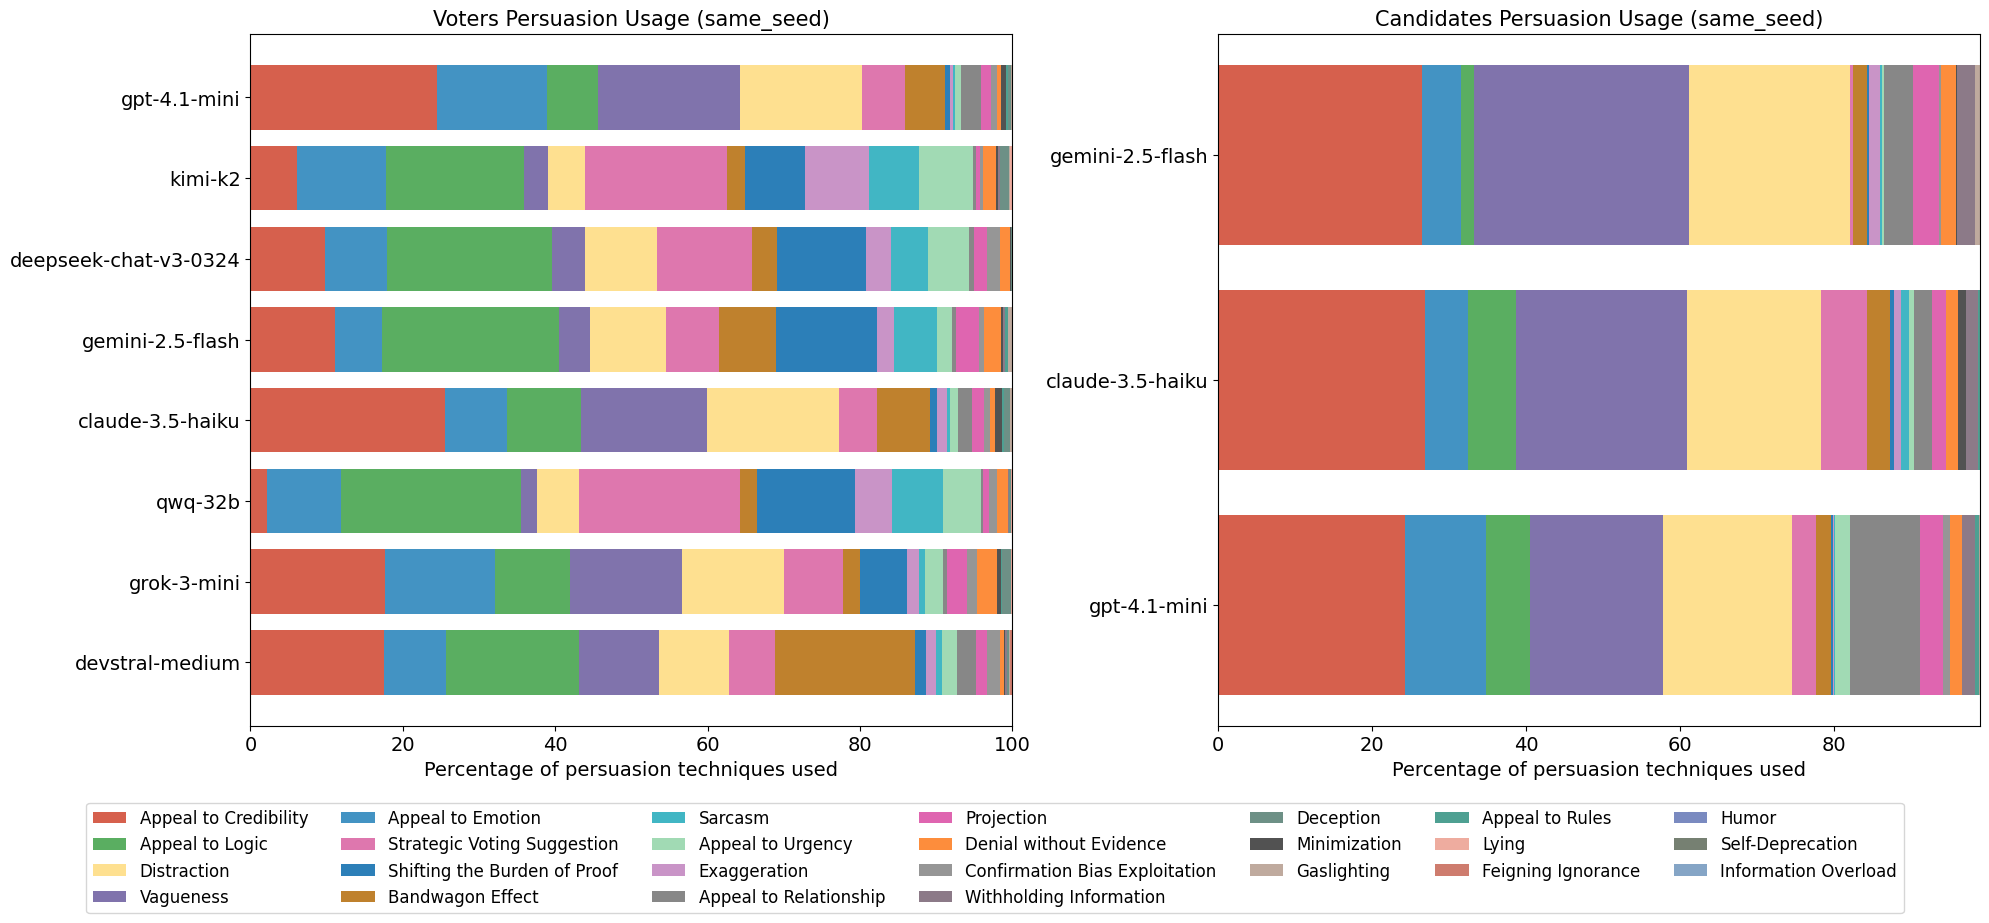

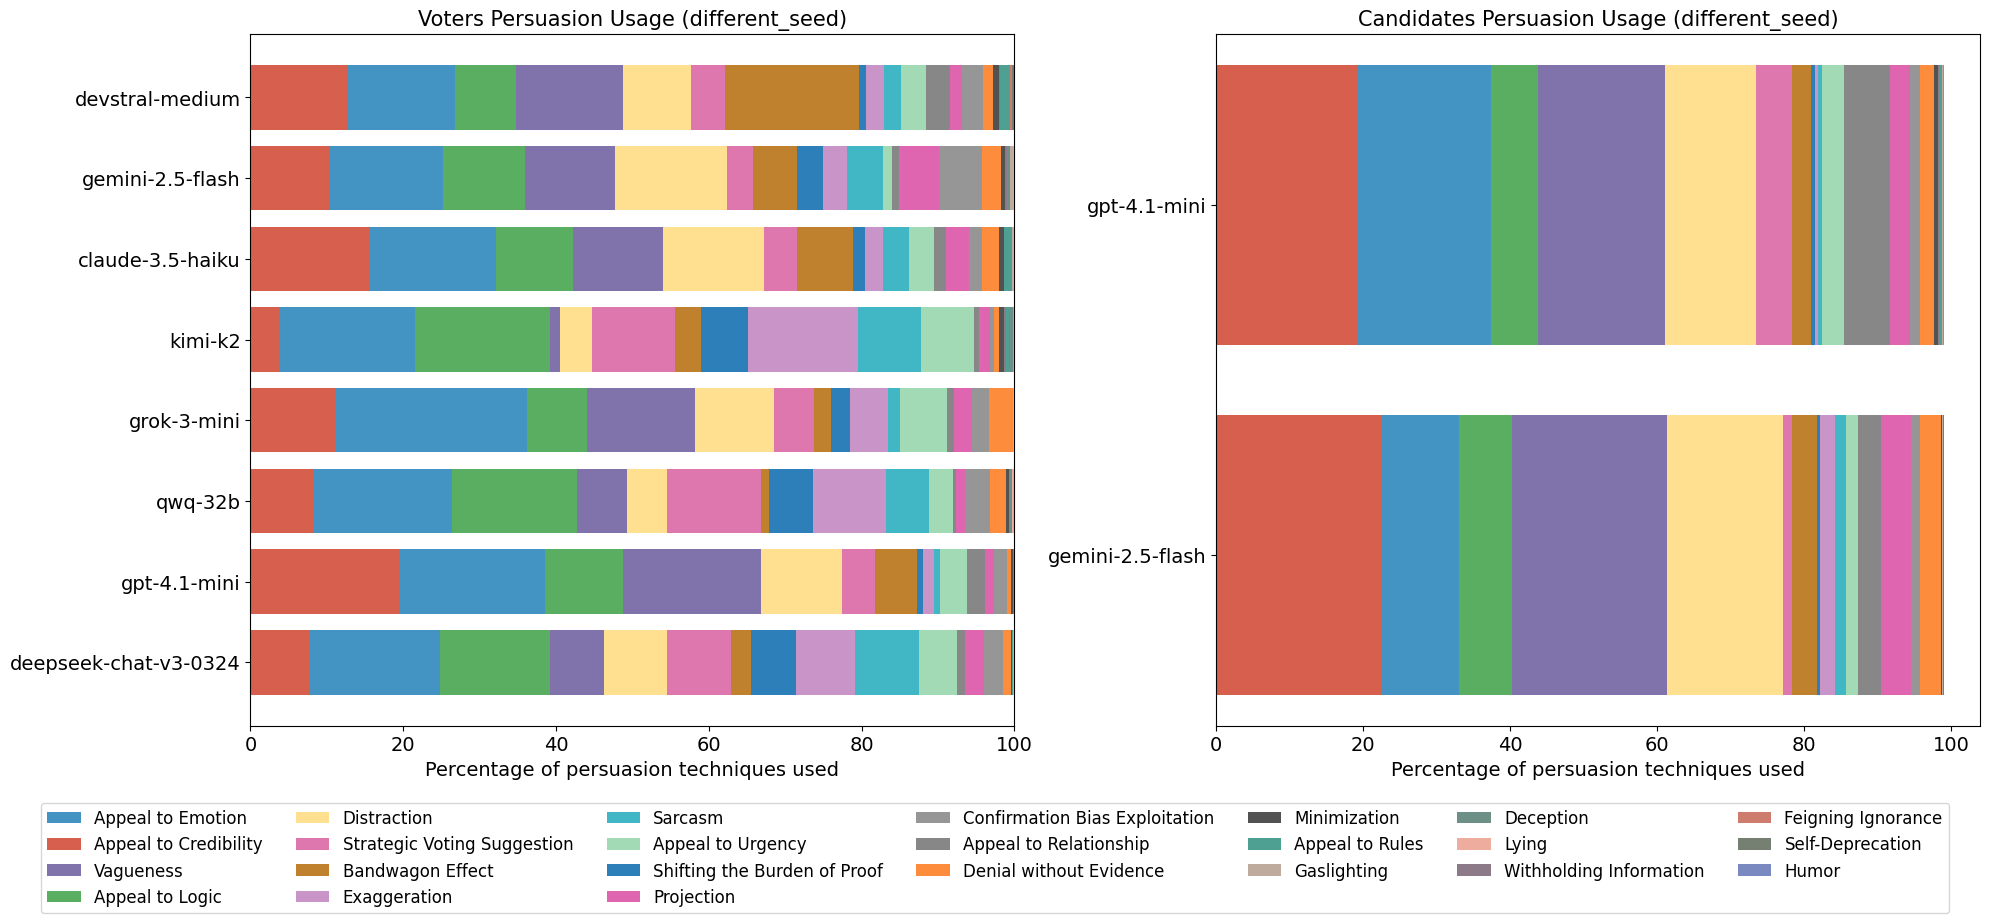

In [ ]:
def plot_persuasion_messages_per_model(
    data, type_data=None, x_axis_label="Percentage of persuasion techniques used"
):
    """Plots percentage of persuasion techniques used per model"""

    voter_techniques, candidate_techniques = (
        process_corrected_combined_techniques_by_type(data)
    )

    percented_voter_techniques = {
        model: {
            technique: (count / sum(techniques.values())) * 100
            for technique, count in techniques.items()
        }
        for model, techniques in voter_techniques.items()
    }
    percented_candidate_techniques = {
        model: {
            technique: (count / sum(techniques.values())) * 100
            for technique, count in techniques.items()
        }
        for model, techniques in candidate_techniques.items()
    }

    # add code here
    create_combined_side_by_side_chart(
        percented_voter_techniques,
        percented_candidate_techniques,
        data,
        type_data,
        x_axis_label=x_axis_label,
    )


same_seed_data = get_data("same_seed")
different_seed_data = get_data("different_seed")

plot_persuasion_messages_per_model(same_seed_data, "same_seed")
plot_persuasion_messages_per_model(different_seed_data, "different_seed")